# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from lightgbm import LGBMClassifier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head() 

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## EDA

Let's check the number of movies and reviews over years.

The amount of movie years has increased exponentially as we get closer to the present date. I would like to explore the gap in movies from 1960-1967 and learn why there is such a gap in the movies made at that point in time. But as a whole, the amount of movies made are increasing as we get closer to modern day time. Also, the number of reviews per movie has increased over the years, which makes sense with out ability to give reviews over the internet and have more access to being able to share our reviews. 

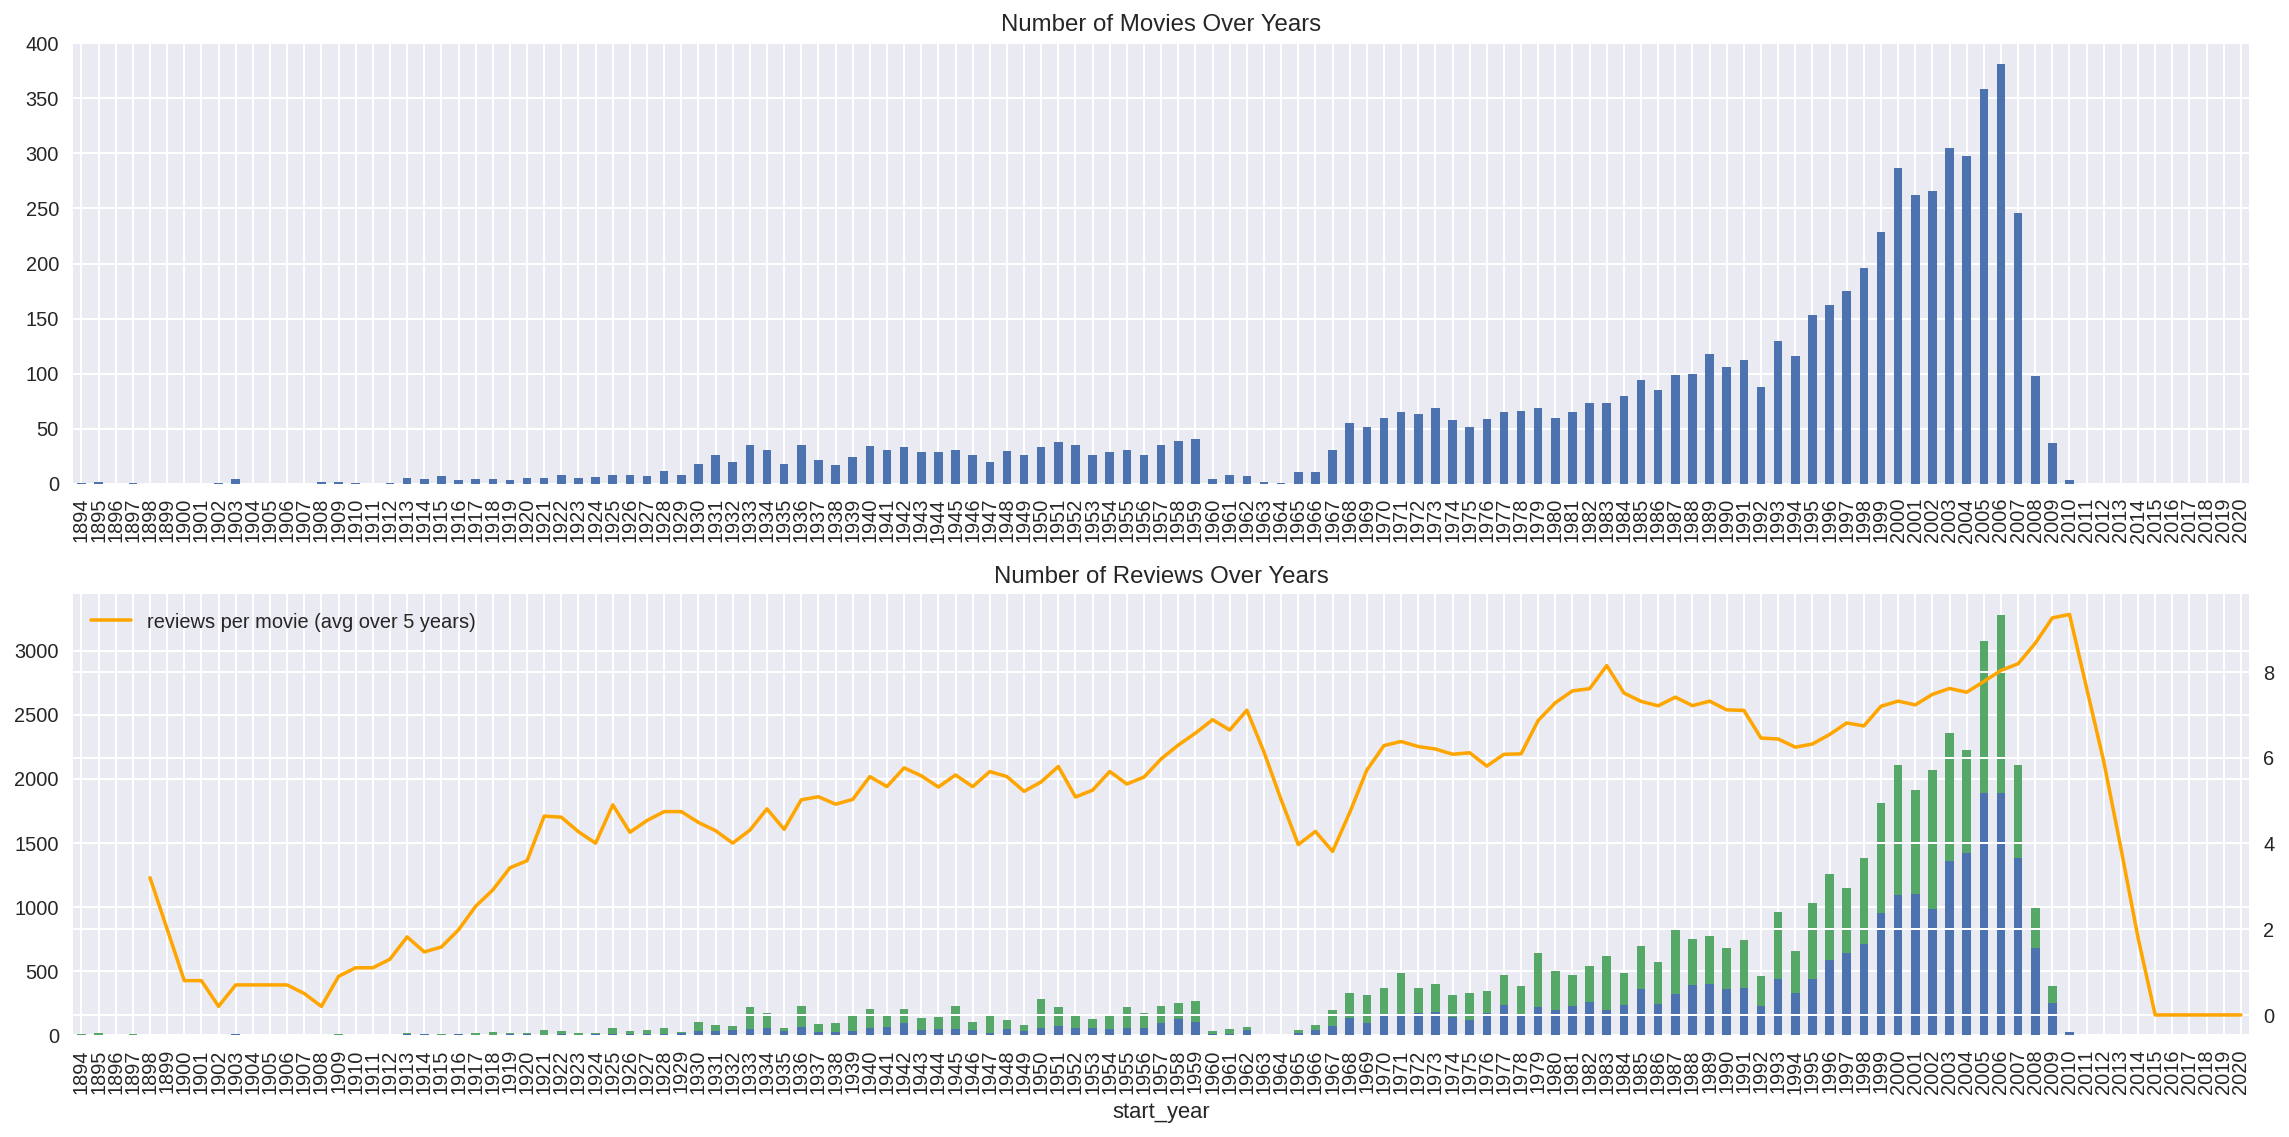

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

The distribution of reviews per movie peaked in the ranges of 0 to 10 reviews and started decline after that, almost bottoming out around the 25 mark of reviews. Around 30 views we have a blip of reviews, and then it settles back in to declining to 0.

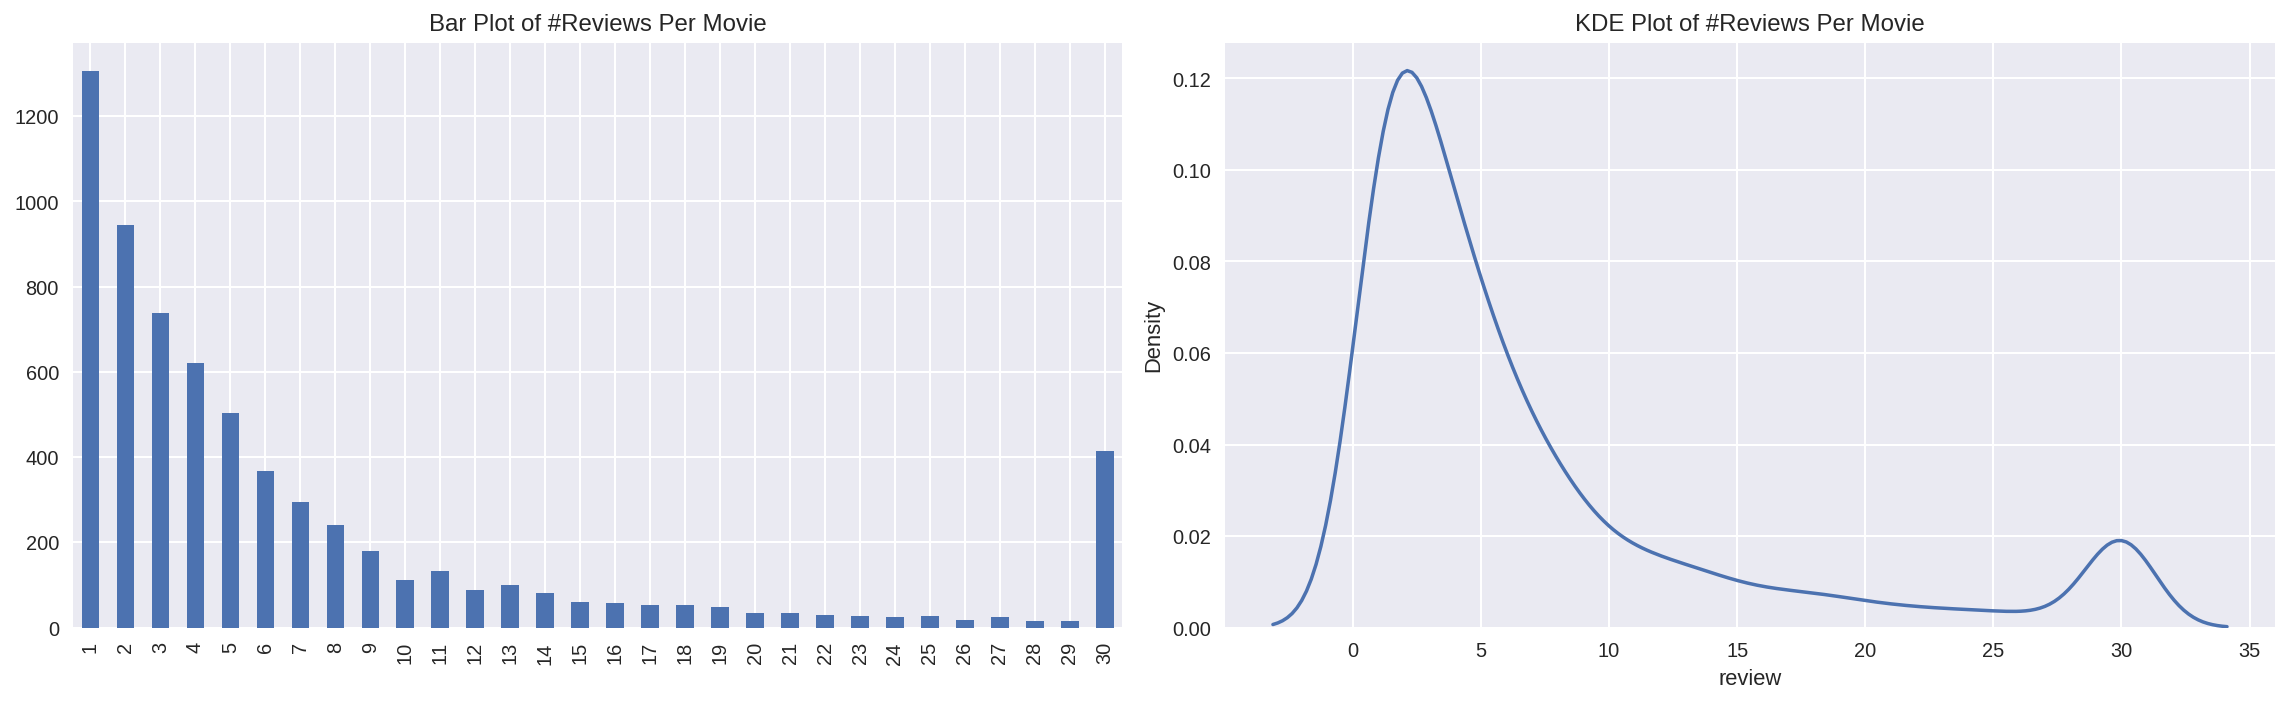

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

The amount of positive and negative reviews is split very close to even when looking at our plot with negative reviews slightly outweighing the positive reviews. 

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pos', ylabel='count'>

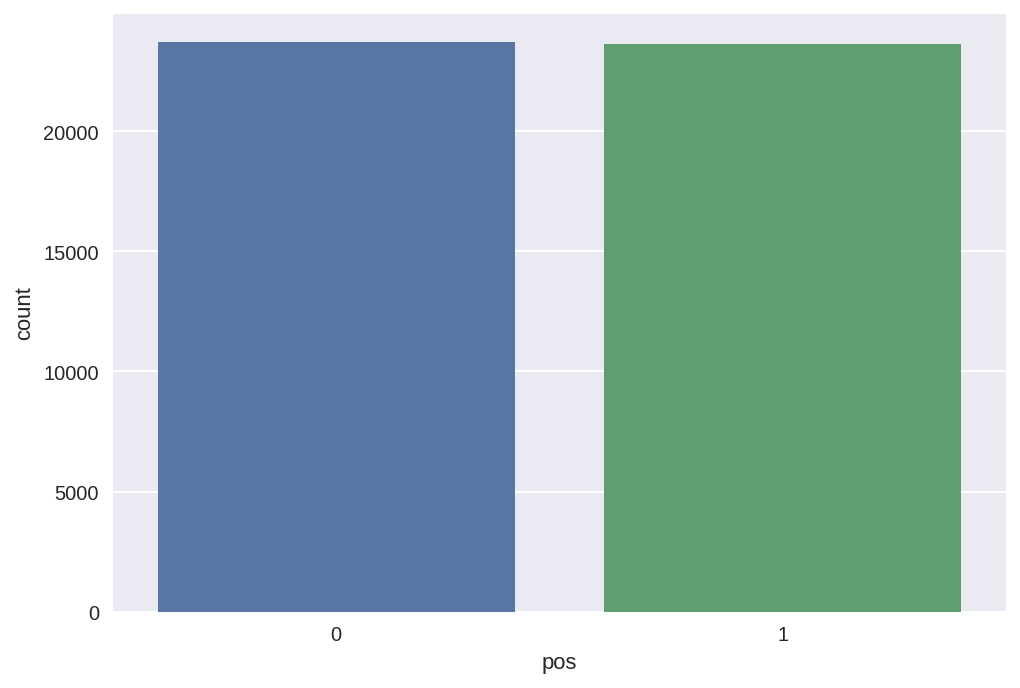

In [9]:
sns.countplot(df_reviews['pos'])

The training and test sets shows a high value of ratings in the 1 and 10 range with 1 slightly outnumbering the number of 10 ratings. There are very few or no 5 and 6 values in the rating showing that movies are typically either loved or hated and very little in between. The 2-4 ratings and the 7-9 ratings have very close to the same amount of values throughout, being very close to the 2000 range for each rating totaling just over 6000 for 2-4 and 7-9. 

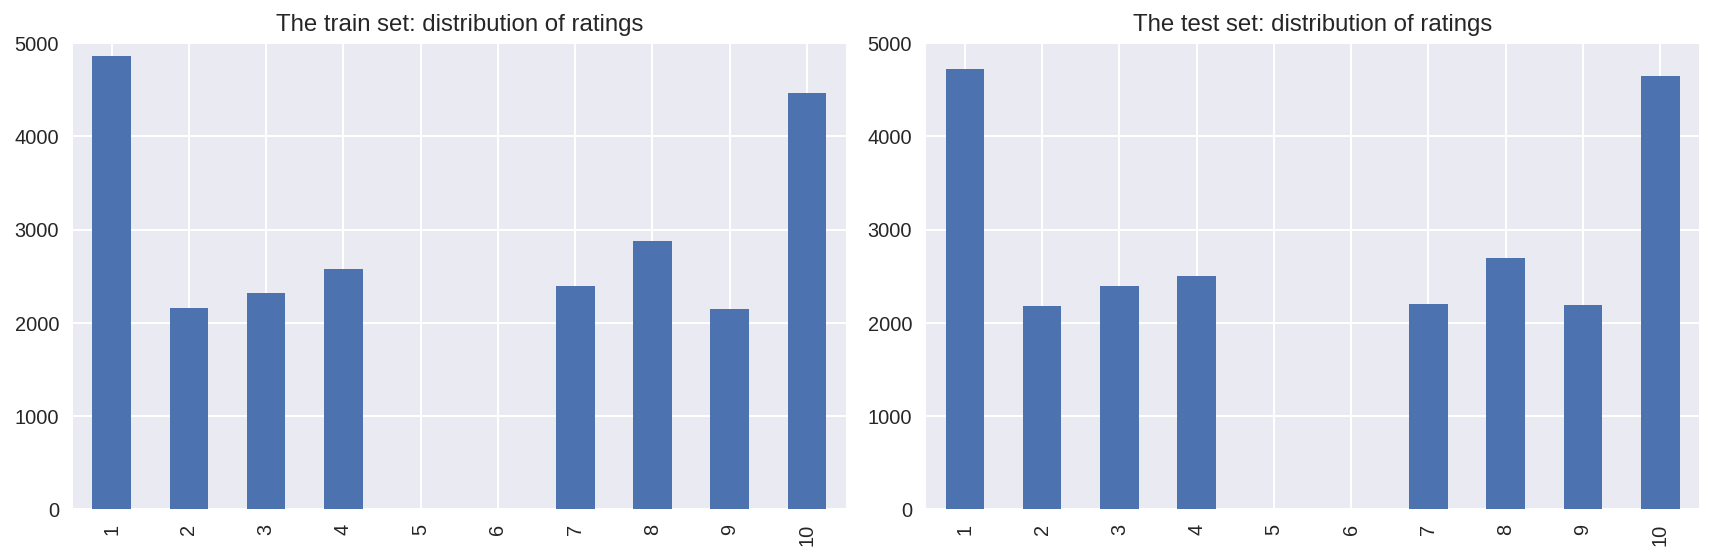

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

The polarity for the positive and negative reviews per movie spiked from 0-10 and then smoothed out around the 0.025 range for the rest of the graph. The 'negative' reviews spiked very high, close to 0.200 while the 'positive' reviews spiked only to the max of 0.075.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


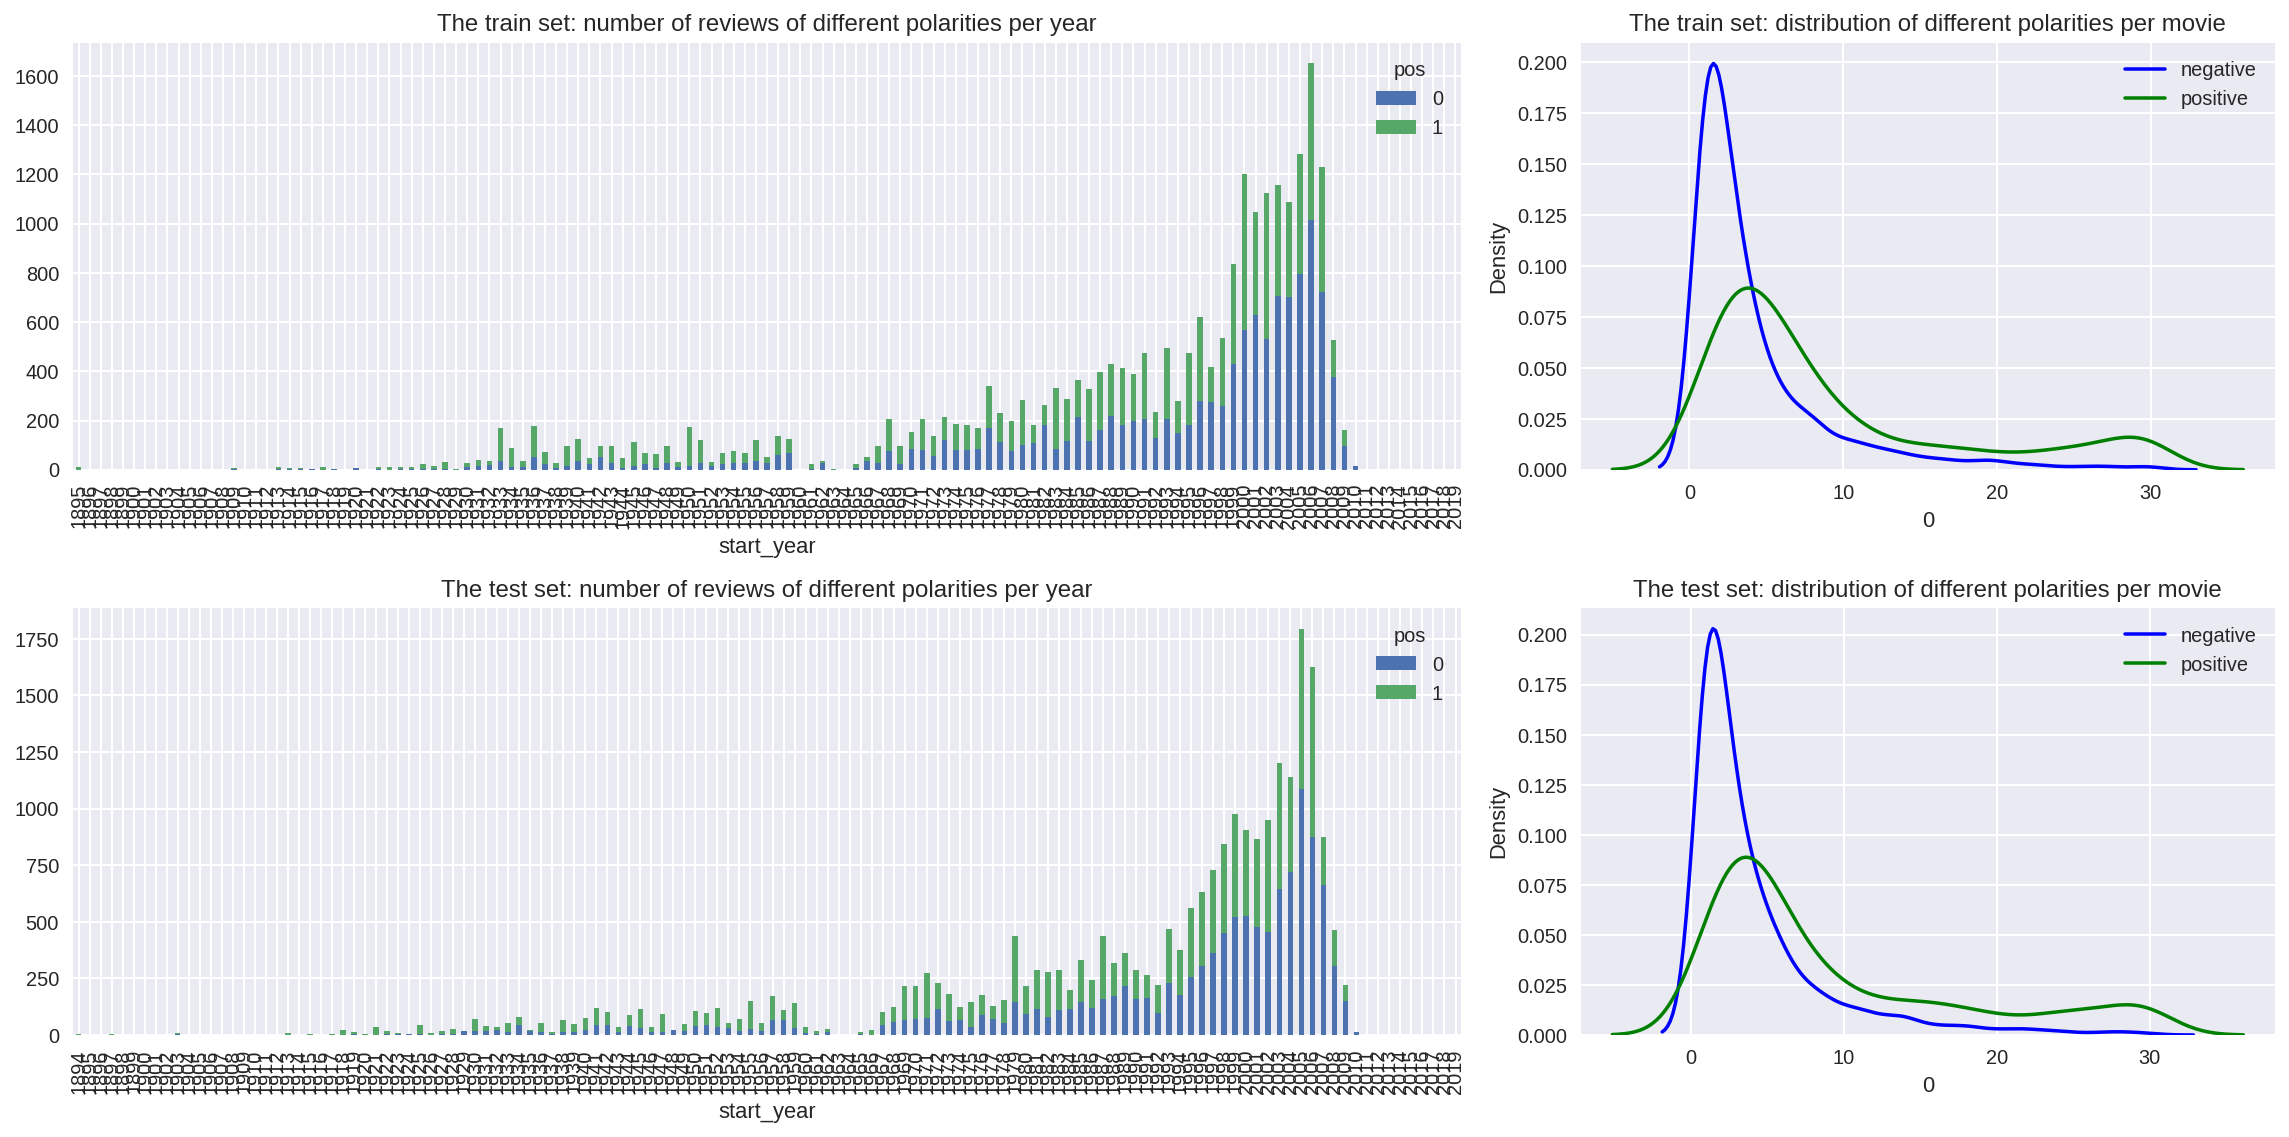

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [14]:
def clear_text(text):
    
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, ' ', text)
    text = text.split()
    text = ' '.join(text)
    return text

def lemmatize(text):

    doc = nlp(text.lower())
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [15]:
df_reviews['review_norm'] = [lemmatize(clear_text(x)) for x in df_reviews['review']]

In [16]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage imply that warren beatty and goldie...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell do they get this make present its...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there be no real story the film seem more like...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teen in singa...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,I be totally agree with garryjohal from singap...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

df_reviews_train = df_reviews_train.drop('review', axis=1)

df_reviews_test = df_reviews_test.drop('review', axis=1)

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 17)
(23535, 17)


In [18]:
df_reviews_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23796 entries, 0 to 47257
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           23796 non-null  object 
 1   title_type       23796 non-null  object 
 2   primary_title    23796 non-null  object 
 3   original_title   23796 non-null  object 
 4   start_year       23796 non-null  int64  
 5   end_year         23796 non-null  object 
 6   runtime_minutes  23796 non-null  object 
 7   is_adult         23796 non-null  int64  
 8   genres           23796 non-null  object 
 9   average_rating   23796 non-null  float64
 10  votes            23796 non-null  Int64  
 11  rating           23796 non-null  int64  
 12  sp               23796 non-null  object 
 13  pos              23796 non-null  int64  
 14  ds_part          23796 non-null  object 
 15  idx              23796 non-null  int64  
 16  review_norm      23796 non-null  object 
dtypes: Int64(1),

In [19]:
X_train, X_test, y_train, y_test =  df_reviews_train, df_reviews_test, train_target, test_target

## Working with models

### Model 0 - DummyClassifier

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train, y_train)

DummyClassifier()

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


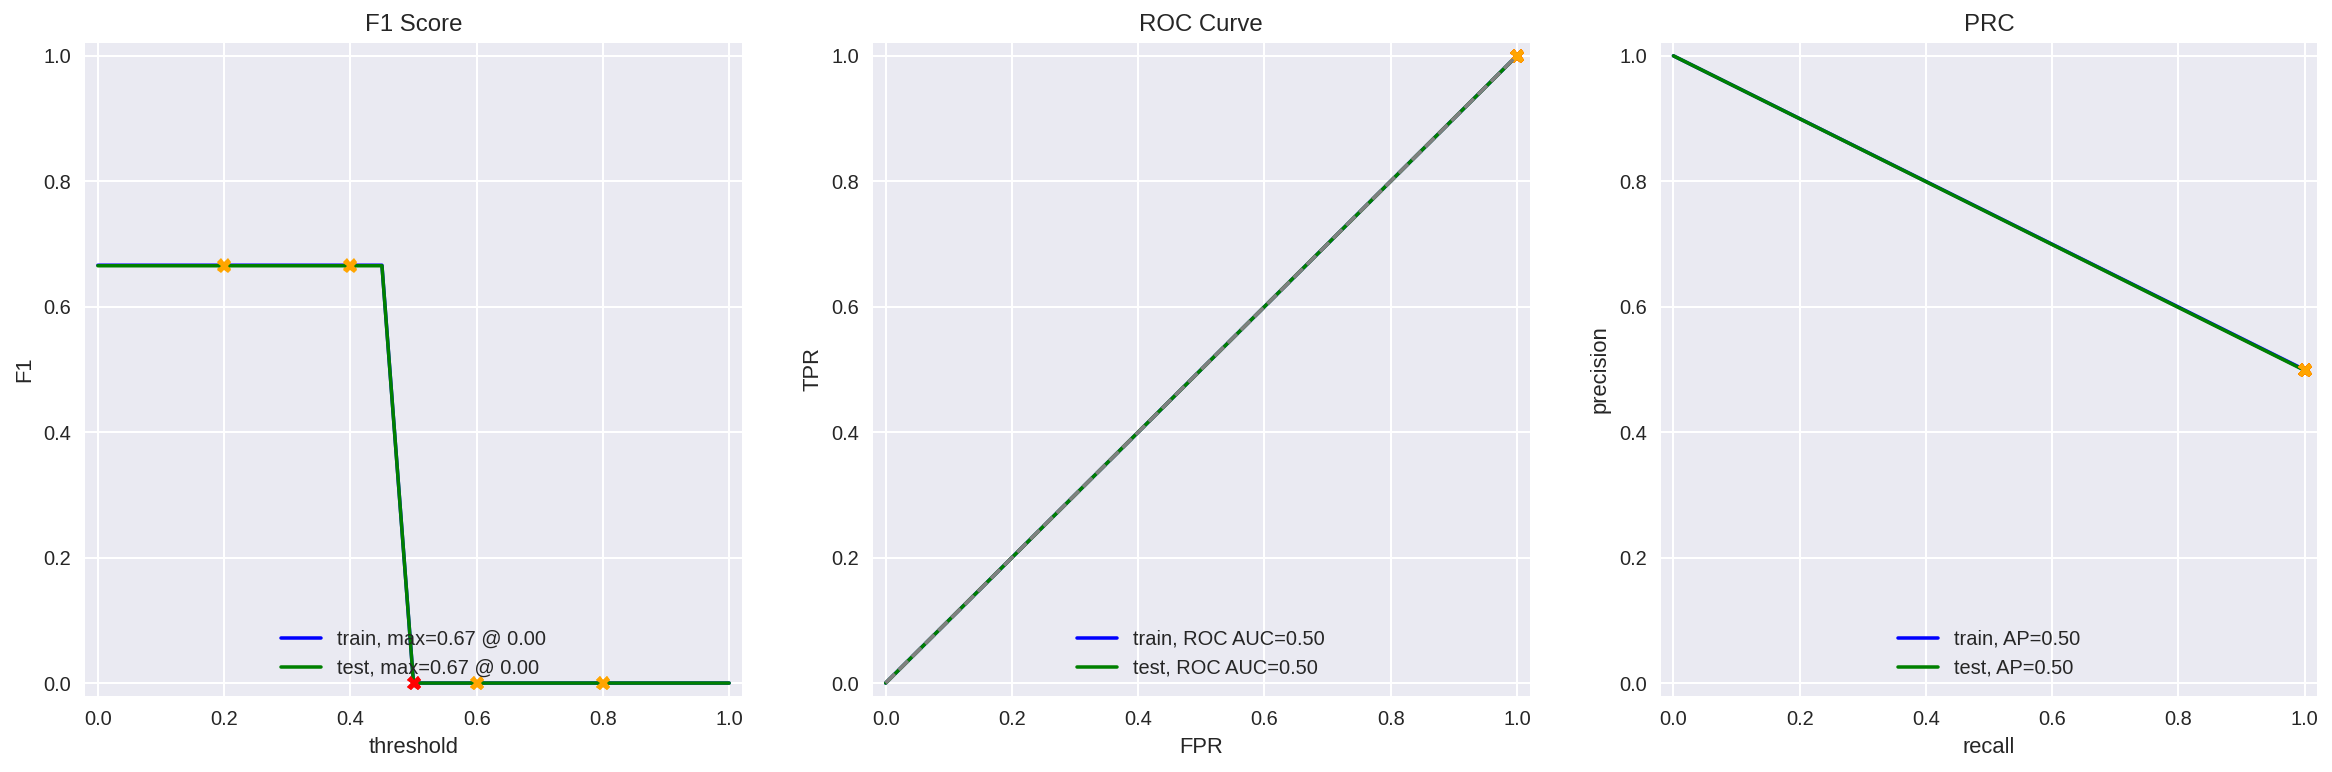

In [22]:
evaluate_model(dummy_model, X_train, y_train, X_test, y_test)

### Model 1 - NLTK, TF-IDF and LR 

Used 10,000 max_features because the error message without it said that it was expecting 10,000 and received 58545 per sample. 

TF-IDF

In [23]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [24]:
tfidv=TfidfVectorizer(strip_accents='ascii',lowercase =True, max_features=10000,analyzer='word', token_pattern=r'\w{3,}', 
                 stop_words = "english")   
X_train_tfidv = tfidv.fit_transform(df_reviews_train['review_norm'].values)

In [25]:
model_1 = LogisticRegression().fit(X_train_tfidv, y_train)
y_pred = model_1.predict(tfidv.transform(df_reviews_test['review_norm'].values))
X_test_tfidv = tfidv.transform(df_reviews_test['review_norm'].values)

          train  test
Accuracy   0.92  0.87
F1         0.92  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


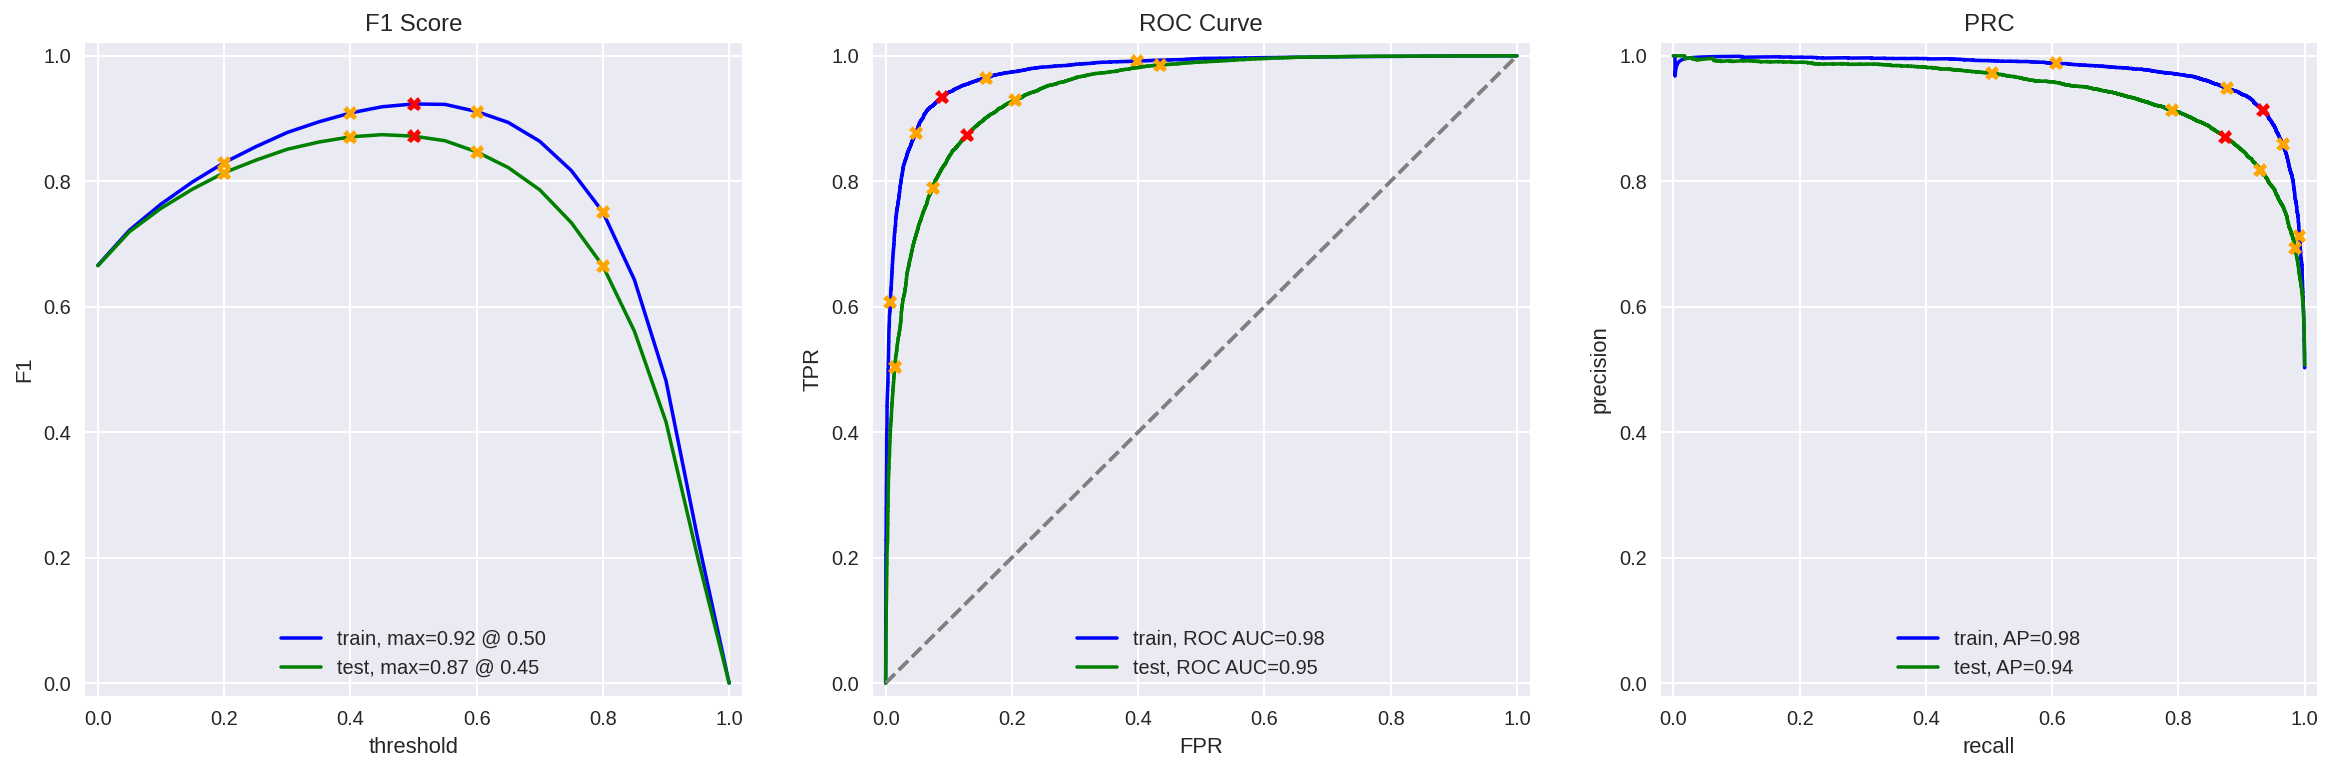

In [26]:
evaluate_model(model_1, X_train_tfidv, y_train, X_test_tfidv, y_test)

### Model 2 - LGBM Classifier

In [27]:
from lightgbm import LGBMClassifier

In [28]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train_tfidv, y_train)
y_pred = lgbm_model.predict(X_test_tfidv)

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


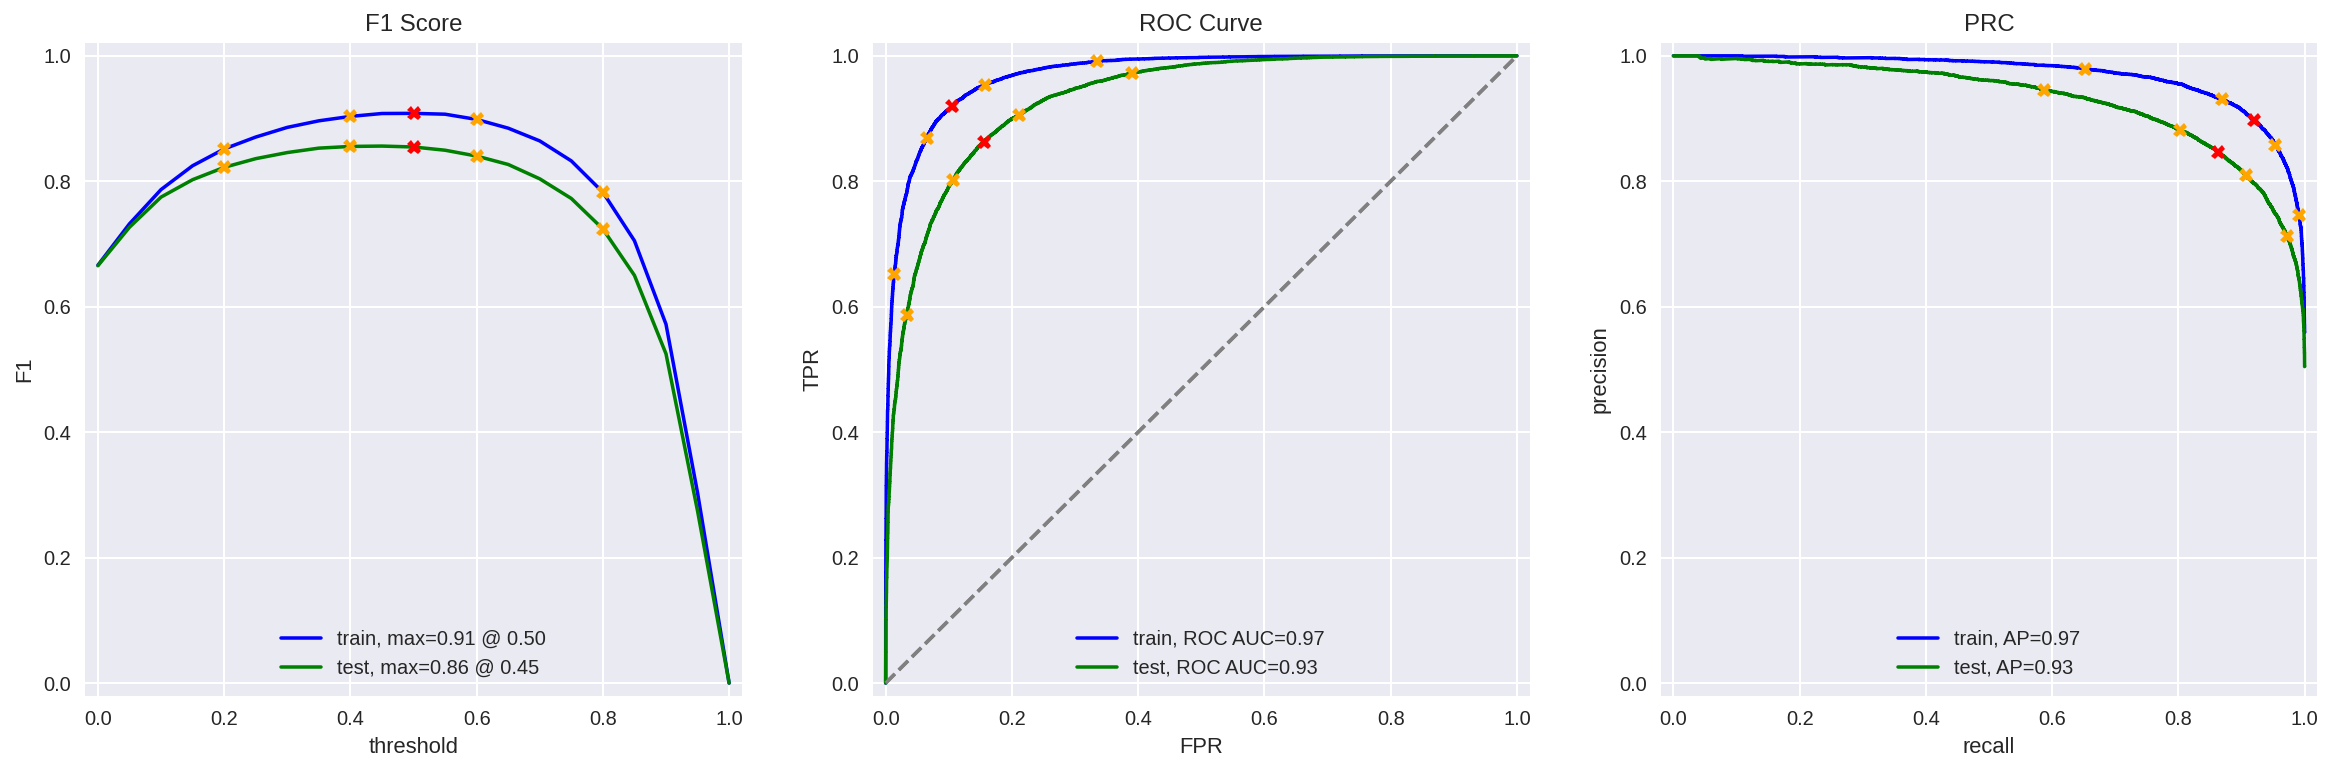

In [29]:
evaluate_model(lgbm_model, X_train_tfidv, y_train, X_test_tfidv, y_test)

###  Model 3 - Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

          train  test
Accuracy   0.91  0.82
F1         0.91  0.83
APS        0.97  0.90
ROC AUC    0.97  0.91


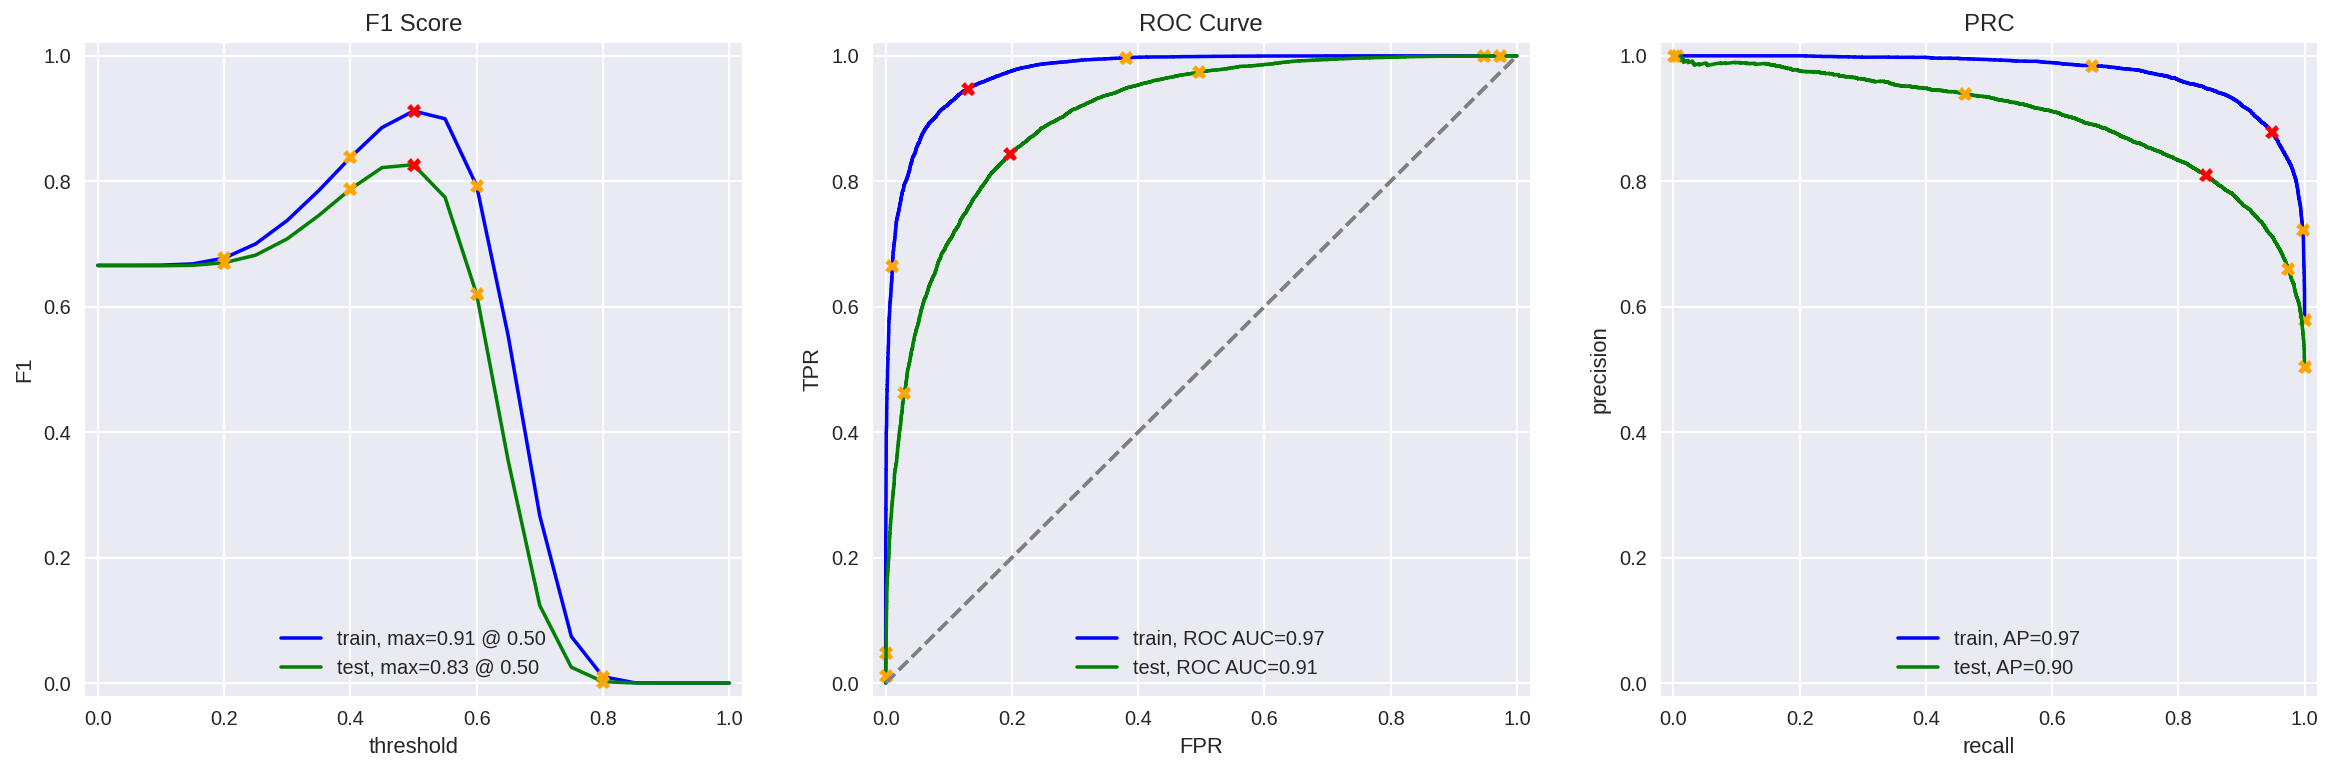

In [31]:
rfc_model = RandomForestClassifier(n_estimators=50, max_depth=20)
rfc_model.fit(X_train_tfidv, y_train)
evaluate_model(rfc_model, X_train_tfidv, y_train, X_test_tfidv, y_test)

###  Model 6 - BERT - Not going to Run BERT because of the length it would take on my computer.

In [32]:
# import torch
# import transformers

In [33]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [34]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []

#     # text to padded ids of tokens along with their attention masks
    
#     # <put your code here to create ids_list and attention_mask_list>
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Using the {device} device.')
    
#     # gettings embeddings in batches

#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         # <put your code here to create attention_mask_batch
            
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [35]:
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [36]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [37]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [42]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = [lemmatize(clear_text(x)) for x in my_reviews['review']]

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move I really app...


Reviews of the Dummy Model

In [70]:
dummy_model_reviews_pred_prob = dummy_model.predict_proba(tfidv.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{dummy_model_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  I do not simply like it not my kind of movie
0.50:  well I be bored and feel asleep in the middle of the movie
0.50:  I be really fascinated with the movie
0.50:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.50:  I do not expect the reboot to be so good writer really care about the source material
0.50:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.50:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.50:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Reviews from the Logistic Regression Model

In [71]:
texts = my_reviews['review_norm']

model1_reviews_pred_prob = model_1.predict_proba(tfidv.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{model1_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  I do not simply like it not my kind of movie
0.08:  well I be bored and feel asleep in the middle of the movie
0.53:  I be really fascinated with the movie
0.13:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.16:  I do not expect the reboot to be so good writer really care about the source material
0.51:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.94:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Reviews from the LGBM model

In [72]:
lgbm_model_reviews_pred_prob = lgbm_model.predict_proba(tfidv.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{lgbm_model_reviews_pred_prob[i]:.2f}:  {review}')


0.57:  I do not simply like it not my kind of movie
0.29:  well I be bored and feel asleep in the middle of the movie
0.62:  I be really fascinated with the movie
0.45:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.57:  I do not expect the reboot to be so good writer really care about the source material
0.60:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.31:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.79:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Reviews from the Random Forest Classifier Model

In [73]:
rfc_model_reviews_pred_prob = rfc_model.predict_proba(tfidv.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{rfc_model_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  I do not simply like it not my kind of movie
0.55:  well I be bored and feel asleep in the middle of the movie
0.56:  I be really fascinated with the movie
0.54:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.60:  I do not expect the reboot to be so good writer really care about the source material
0.53:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.47:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.62:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


## Conclusions

Viewing the Scores of the different models again to form our conclusions based off of them. 

I checked several different models and used different methods for this project. The use of lemmatization, TF-IDF, a bag of words, and evaluating metrics including F1_score, accuracy, ROC AUC, and APS. I think there are some adjustments that could be made that might be able to make our F1_score be even higher for a few of the models, but the TfidV model did go above the requisite requirement. Below are the model results: 

                                                            Dummy Model

|        |train | test |
|------  |------|------|
|Accuracy|0.5   |0.5   |
|F1      |0.0   |0.0   |
|APS     |0.5   |0.5   |
|ROC AUC |0.5   |0.5   |


                                                            RFC Model

|        |train | test |
|------  |------|------|
|Accuracy|0.91  |0.82  |
|F1      |0.91  |0.83  |
|APS     |0.97  |0.90  |
|ROC AUC |0.97  |0.91  |

                                                            LGBM Model

|        |train | test |
|------  |------|------|
|Accuracy|0.91  |0.85  |
|F1      |0.91  |0.85  |
|APS     |0.97  |0.93  |
|ROC AUC |0.97  |0.93  |

                                                       TfidV/Logistic Model

|        |train | test |
|------  |------|------|
|Accuracy|0.92  |0.87  |
|F1      |0.92  |0.87  |
|APS     |0.98  |0.94  |
|ROC AUC |0.98  |0.95  |

We can see that the best result in our testing group with the F1_Score is the Tfidv/Logistic Model with 0.87 which seems to make sense. The LGBM Model performed slightly worse with an F1_score of 0.85. The RFC model and the dummy model did not meet our requisite requirements. 

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions